In [216]:
import numpy as np 
import matplotlib.pyplot as plt 

from scipy.integrate import odeint

import seaborn as sns 

# sns.set_style('darkgrid')
sns.set(style="ticks")

In [212]:
# Parameters of Falcton 9 1:30 ratio.
m = 100000
l1 = 3.8677 # Length between COG and downwards nozzles  
l2 = 3.7 # Length between COG and upwards nozzles
ln = 0.1892
g = 9.81

tau = 0.01 # toruqe
inertia = 482.2956 # Moment of inertia

labels = [r'$x$',r'$\dot{x}$',r'$y$', r'$\dot{y}$',r'$\theta$',r'$\dot{\theta}$']

# Rocket landing physics

For the following notebook I want to delve into the problem of rocket landing using classical control theory appraoch of Model Predictive Control. 

Assume our rockets consists of 3 nozzels such that the acting forces are: $F_E,F_R,F_L$. 

Note that $F_E$ is the force acting by the nozzle at the bottom of the rockets and the two others are right and left nozzles respectively. We will use $F_s = F_L - F_R$ to account the force acting from the side nozzles. 

For simplictly we assume the rocket to be 2-dimensional hence we are tracking it's $x,y$ position and also the angle $\theta$ created by the rocket with respect to the y-axis. 

Another angle of interest is $\phi$ that is the angle created by the nozzle with respect to the rocket's direction. Note that this angle is controlled by us.

For simplictly vector forces would be represented by the corresponding angle and multiplied 
by the magnitude. Hence for example:

$$ \vec{F_E} = F[\sin(\theta + \phi),\cos(\theta + \phi)] $$

Note the $\phi$ term accounts for the degree of the nozzle as that's the direction the thrust expels at.

The length of the distance between the rocket's Center Of Gravity (COG) and the bottom nozzle and the side nozzles at the top of the rockets are $l_1,l_2$ respectively. 
We denote $l_n$ for the length of the nozzle and $l_s$ for the width of the rocket.

The following differential equations are of main interest of us:

$$ \ddot{x} = \frac{F_E\theta + F_E\phi + F_S}{m}$$

$$ \ddot{y} = \frac{F_E - F_E\phi\theta - F_s\theta -mg}{m}$$

$$ \ddot{\theta} = \frac{-F_E\phi(l_1+l_n)+l_2F_s}{J}$$

$$ \dot{m} = -\alpha(\beta F_e-F_s)$$
$$ J \ddot{\phi}=\tau$$

Equations (1)-(2) are simple applications of the $F=ma$ equation. 

Equations (3) and (5) are the relation $\tau=I\cdot\alpha$, $\tau$ equals the torque force (rotational force), $\alpha$ equals the angular acceleration and $I$ equals moment of inertia (it's resistance to change in motion).

Equation (4) describes the linear relation between the decrease in mass and the applied thrust.

# System representation

These control equations can be described generally as:

$$ \dot{x} = f(x(t),u(t)) $$

$$ x = [x,\dot{x},y,\dot{y},\theta,\dot{\theta}]$$
$$ u = [F_E,F_s,\phi] $$

with $x$ the state vector and $u$ the action vector.

Using the corresponding differential equations for $x,y,\theta$ and reduce the second order into first order by adding equations of the form $x=\dot{x}$ we have 6 equations for $f$.

To solve the control problem we first linearize the differential equations by expanding the Taylor's series around an equilibrium point 
$$f(x(t),u(t))=0$$

The point $u=[mg,0,0]$ can be found easily as solution.
One can solve analytically for the jacobian of $f$ with respect to $x$ and $u$ but we will use finite difference method.

In [213]:
def rocket_dynamics(x, t,u):
    x,dx,y,dy,theta,dtheta = x 
    f_e,f_s,phi = u 
    ddx = (f_e*theta + f_s*phi +f_s)/m
    ddy = (f_e - f_e*phi*theta - f_s*theta - m*g)/m
    ddtheta = (-f_e*phi*(l1+ln) + l2*f_s)/inertia
    return [dx,ddx,dy,ddy,dtheta,ddtheta]


def linearaize_diff_eq(x,u,epsilon=0.001):
    x_plus = x + epsilon*np.identity(len(x))
    x_minus = x - epsilon*np.identity(len(x))
    grads_x = []
    for i in range(len(x)):
        grad_xi = (np.array(rocket_dynamics(x_plus[i,:],0,u)) - np.array(rocket_dynamics(x_minus[i,:],0,u)))/(2*epsilon)
        grads_x.append(grad_xi)
    A = np.array(grads_x).T
    
    
    u_plus = u + epsilon*np.identity(len(u))
    u_minus = u - epsilon*np.identity(len(u))
    grads_u = []
    for i in range(len(u)):
        grad_ui = (np.array(rocket_dynamics(x,0,u_plus[i,:])) - np.array(rocket_dynamics(x,0,u_minus[i,:])))/(2*epsilon)
        grads_u.append(grad_ui)
    B = np.array(grads_u).T
    return A,B

def visualize_simulation(x,u,seconds=1,Hrtz=60):
    t = np.linspace(0,seconds,seconds*Hrtz)
    simulation = odeint(rocket_dynamics,x,t,args=(u,))
    fig,axis = plt.subplots(3,2,figsize=(15,5))

    fig.suptitle("Rocket landing simulaton results")
    for i,l in enumerate(labels):
        axis[i//2,i%2].plot(t, simulation[:,i])
        axis[i//2,i%2].grid()
        axis[i//2,i%2].set_title(l)
        # axis[i//2,i%2].set_xlabel('t')

    plt.tight_layout()
    return simulation

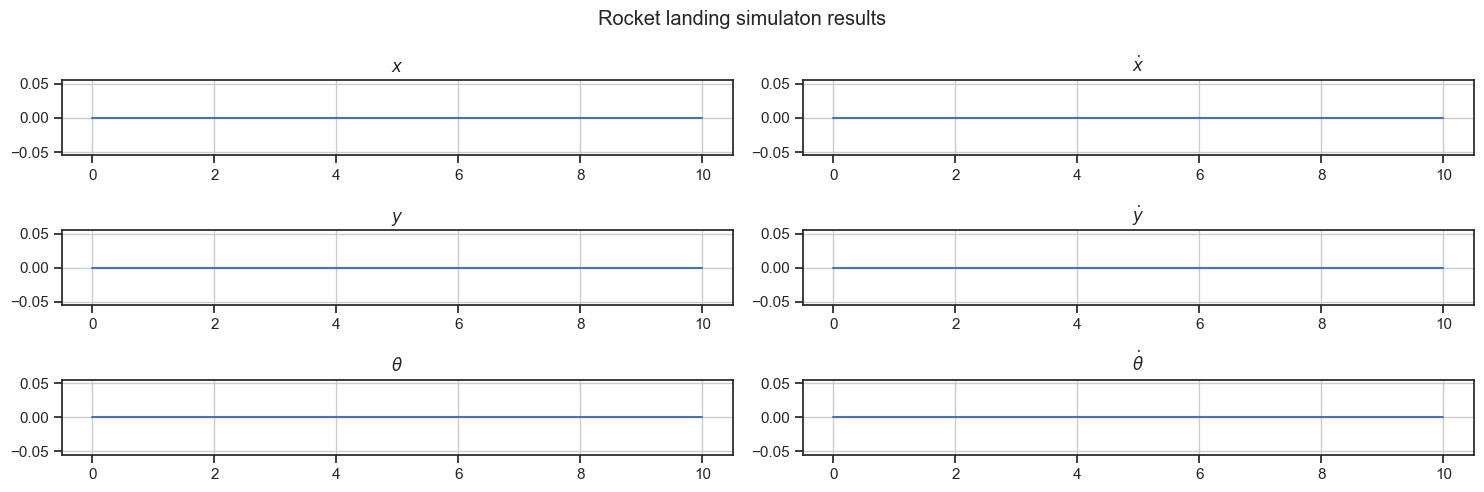

In [217]:
x0 = [0,0,0,0,0,0]
equilibrium_point = [m*g,0,0]
simulation = visualize_simulation(x0,equilibrium_point,10)

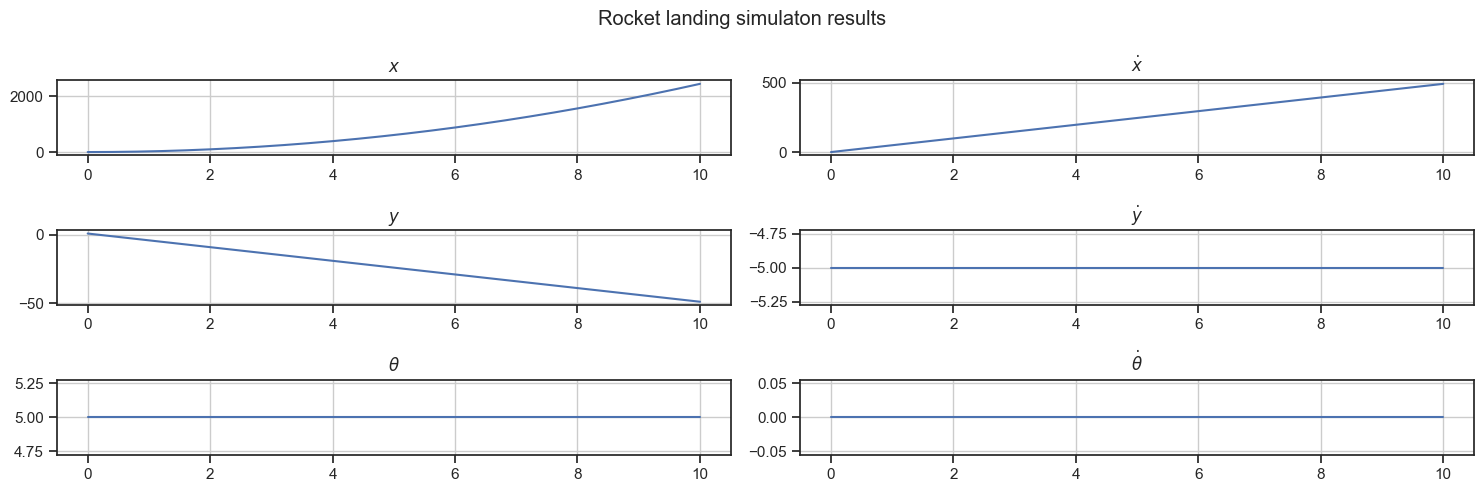

In [218]:
x0 = [0.5,0,1,-5,5,0]
equilibrium_point = [m*g,0,0]
simulation = visualize_simulation(x0,equilibrium_point,10)

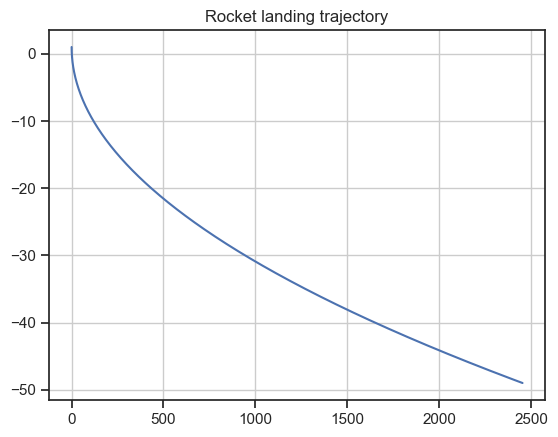

In [219]:
plt.grid()
plt.title("Rocket landing trajectory")
plt.plot(simulation[:,0],simulation[:,2]);

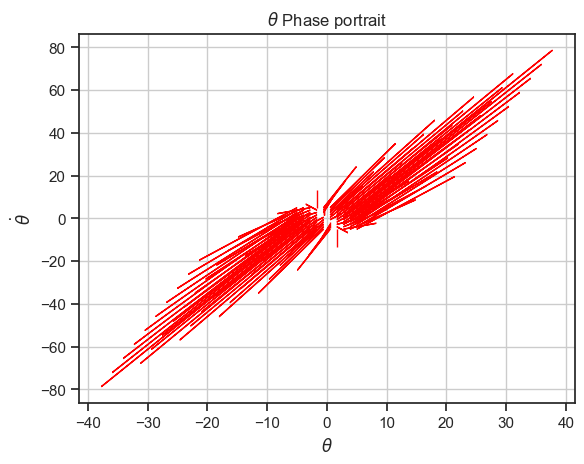

In [223]:
X0 = np.array([1.5,0,230,-10,0,0])
thetas = np.linspace(-5,5,10)
dthetas = np.linspace(-5,5,10)

u = [m*g,0,0]
for theta in thetas:
    for dtheta in dthetas:
        x0 = X0 
        x0[4] = theta 
        x0[5] = dtheta
        results = odeint(rocket_dynamics,x0,[1,2],args=(u,))[-1]
        dx = results[0] - x0[0] + 1e-5
        dy = results[1] - x0[1] + 1e-5
        plt.arrow(theta,dtheta,dx,dy,length_includes_head=True,head_width=0.08, head_length=0.00002,color='red')
        
plt.grid()
plt.title(r"$\theta$ Phase portrait")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.show()

# LQR

In [224]:
def calculate_derivative_analytically(x,u):
    f_e = u[0]
    f_s = u[1]
    phi = u[2]
    theta = x[4]
    A = np.array(
        [[0,1,0,0,0, 0],
        [0,0,0,0,f_e/m,0],
        [0,0,0,1,0, 0],
        [0,0,0,0,(-f_e*phi-f_s)/m,0],
        [0,0,0,0,0,1],
        [0,0,0,0,0,0]]
    )
    B = np.array(
        [[0,0,0],
        [(phi+theta)/m,1/m,f_e/m],
            [0,0,0],
        [(1-phi*theta)/m,-theta/m,-(f_e*theta)/m],
        [0,0,0],
        [-(phi*(l1+ln))/inertia,l2/inertia,-f_e*(l1+ln)/inertia]]
    )
    return A,B

u_cap = [m*g,0,0]
x_cap = [0,0,0,0,0,0]
A,B = calculate_derivative_analytically(x_cap,
                                        u_cap)

Now that we have linearized the problem all left is writing the controller itself that directs the rocket. The first rather vanilla algorithm is LQR. LQR is an optimal control algorithm for a model governed by: 
$$\dot{x} = Ax +Bu $$


In LQR we minimize:

$$ J = \int_{0}^{\infty} (x^{T}Qx + u^{T}Ru)$$

- $Q$: Penalty given for the state
- $R$: Penalty given to execute an action

The optimal control sequence that minimize the function is given by:

$$ u = -Kx$$

$$ K = R^{-1}B^{T}P$$

And $P$ is the solution for the Riccati equation.

Note that the assumption under LQR is that if the dynamics are stable (that is the eigenvalues of the transition matrix has negative real parts) the system will converge to it's equilibrium point when given initial conditions not too far away from it. In the case of rocket landing we linearize the system around our target state vector which is needed to be an equilbrium point and adjust the Q matrix to quantify for the accepted error.


Hence one intuitive way to choose the Q matrix is using a diagonal matrix of the follown form:

$$ Q = [\frac{1}{(\text{accepted error})^2},\dots,\frac{1}{(\text{accepted error})^2}]$$

As for $R$ we wish to give it a penality inversely proportional to the required degree of freedom in that action.

In [225]:
from scipy.linalg import solve_continuous_are
from numpy.linalg import inv

def design_optimal_trajectory(Q,R,x0):
    P = solve_continuous_are(A,B,Q,R)
    K = -inv(R) @ B.T @ P

    def optimal_rocket_dynamics(x, t):
        dot = A @ (x) + B @ (K @ (x)) 
        return dot


    seconds = 10
    t = np.linspace(0,seconds,seconds*60)
    simulation = odeint(optimal_rocket_dynamics,x0,t)
    simulation = simulation + x_cap 

    fig,axis = plt.subplots(3,2,figsize=(15,5))

    fig.suptitle("LQR optimal control results")
    for i,l in enumerate(labels):
        axis[i//2,i%2].plot(range(seconds*60), simulation[:,i])
        axis[i//2,i%2].grid()
        axis[i//2,i%2].set_title(l)

    plt.tight_layout()
    plt.show()
    eigenvals = np.linalg.eigvals(A+B@K)
    return simulation, eigenvals

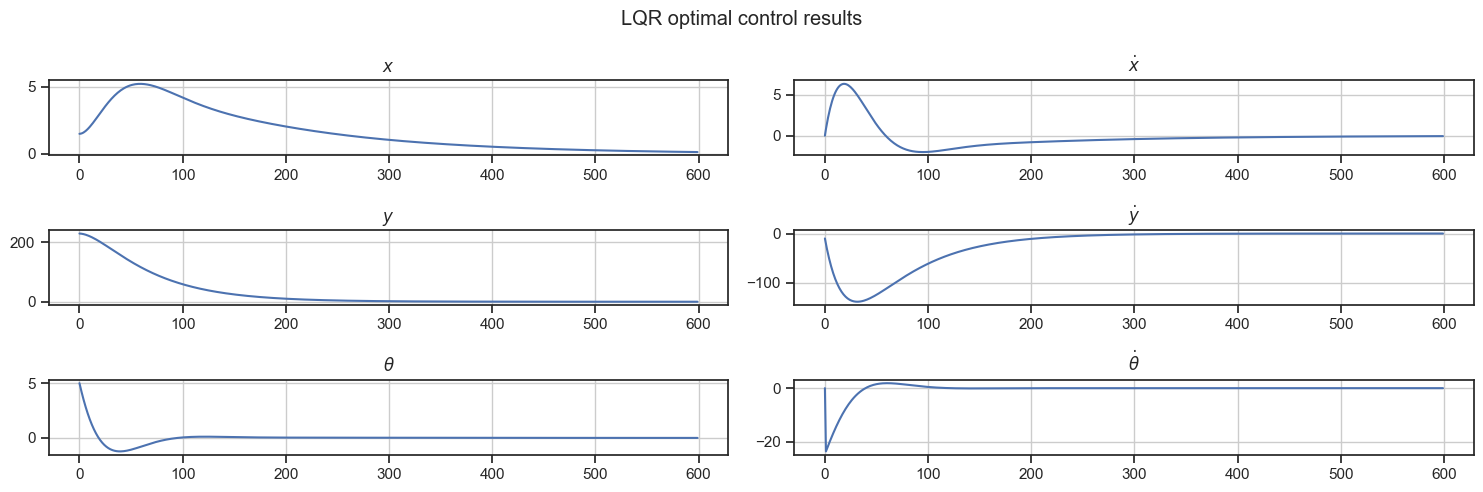

In [226]:
errors = [5,2,0.0001,0.0001,10,2]
Q = np.diag([(1/e)**2 for e in errors])
R = 0.001*np.identity(3)

x0 = np.array([1.5,0,230,-10,5,0])
simulation, eigenvals = design_optimal_trajectory(Q,R,x0)

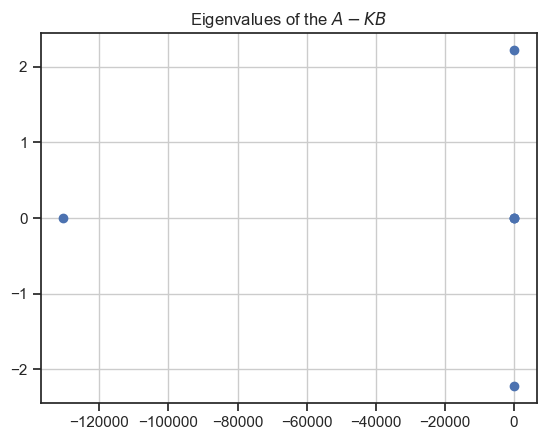

In [227]:
plt.scatter(eigenvals.real,eigenvals.imag)
plt.grid();
plt.title("Eigenvalues of the $A-KB$");

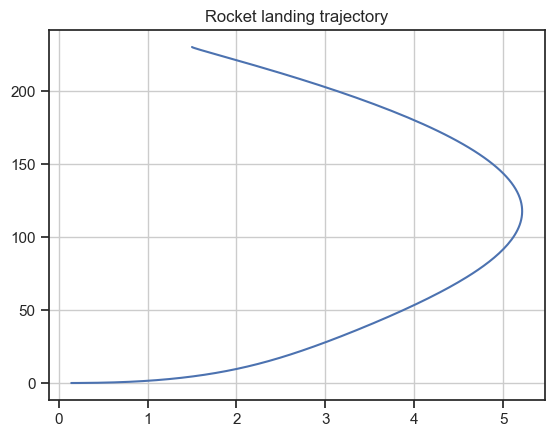

In [229]:
plt.plot(simulation[:,0],simulation[:,2]);
plt.title("Rocket landing trajectory");
plt.grid();

One can observe that the dynamics are stable given that the eigenalues have all negative real parts. And this is present in the simulation where we see the rocket to be smoothly converging to it's equilibrium point.

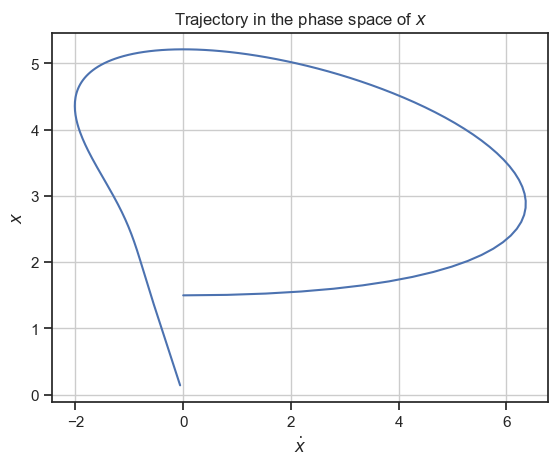

In [230]:
plt.plot(simulation[:,1],simulation[:,0]);
plt.ylabel(r"$x$")
plt.xlabel(r"$\dot{x}$")
plt.title(r"Trajectory in the phase space of $x$")
plt.grid();

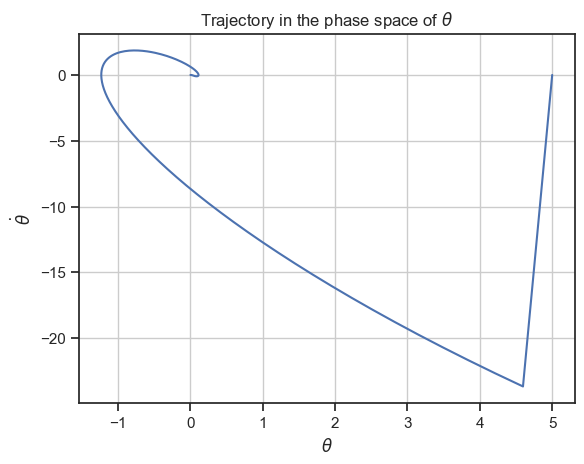

In [231]:
plt.plot(simulation[:,4],simulation[:,5]);
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot{\theta}$")
plt.title(r"Trajectory in the phase space of $ \theta $")
plt.grid();

## Local trajectory stabilization

Given a candidate trajectory $x_0(t),u_0(t)$ one can use it to stabilize the dynamics around it using the same idea of linearization. Instead of linearizing around one stable equilibruim point like in the simlpe non-linear case we linearize over each of the samples of the given trajectory and change coordinates so we are consistent with respect to the Taylor approximation.

$$ \bar{x}(t) = x(t) - x_{0}(t) , \bar{u}(t) = u(t) - u_{0}(t)$$ 

$$ \dot{\bar{x}} \sim \frac{\partial{f(x_0,u_0)}}{\partial{x}}(x-x_0) + \frac{\partial{f(x_0,u_0)}}{\partial{u}}(u-u_0) = A(t)\bar{x} + B(t)\bar{u} $$

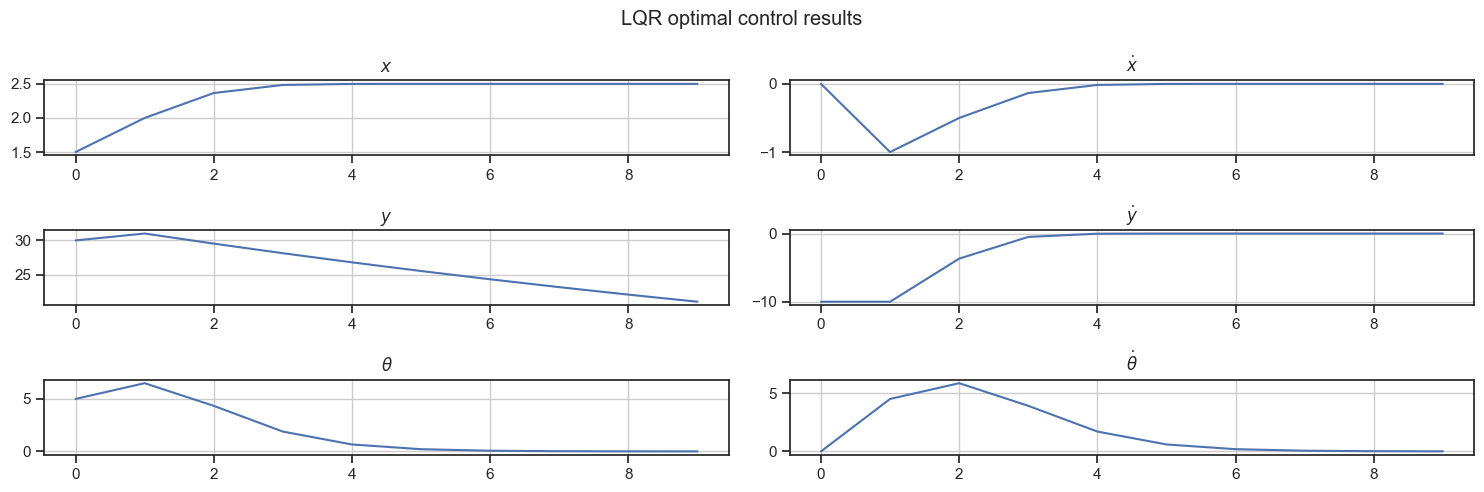

In [232]:
x_final = 2.5

def target_trajectory(v,t):
    x,dx,y,dy,theta,dtheta = v
    x1 = x + (x_final - x)/(1+ np.exp(-t))
    dx1 = x - x_final 
    y1 = 30*np.exp(-0.05*t) + 1
    dy1 = dy * np.exp(-t)
    theta1 =  theta * (0.3 + np.exp(-t))
    dtheta1 = 0.9*theta
    return [x1,dx1,y1,dy1,theta1,dtheta1]

x0 = [1.5,0,30,-10,5,0]
trajectory = [x0]
for t in range(9):
    trajectory.append(target_trajectory(trajectory[-1],t))

trajectory = np.array(trajectory)
fig,axis = plt.subplots(3,2,figsize=(15,5))

fig.suptitle("LQR optimal control results")
for i,l in enumerate(labels):
    axis[i//2,i%2].plot(range(10), trajectory[:,i])
    axis[i//2,i%2].grid()
    axis[i//2,i%2].set_title(l)

plt.tight_layout()
plt.show()

In [233]:
u_cap = [m*g,0,0]
errors = [0.0001,2,0.0001,0.0001,10,2]
Q = np.diag([(1/e)**2 for e in errors])
R = 0.001*np.identity(3)

x0 = [1.5,0,30,-10,5,0]
T,path = [],[]
x = x0
for k in range(len(trajectory)):
    A,B = calculate_derivative_analytically(trajectory[k],u_cap)
    P = solve_continuous_are(A,B,Q,R)
    K = -inv(R) @ B.T @ P

    def optimal_rocket_dynamics(x, t,A,B,K):
        dot = A @ (x - trajectory[k]) + B @ K @ (x - trajectory[k])
        return dot

    t = np.linspace(k,k+1,2)
    x = odeint(optimal_rocket_dynamics,x,t,args=(A,B,K))[-1]

    T.append(t[1:])
    path.append(x)


T = np.concatenate(T)
path = np.array(path)

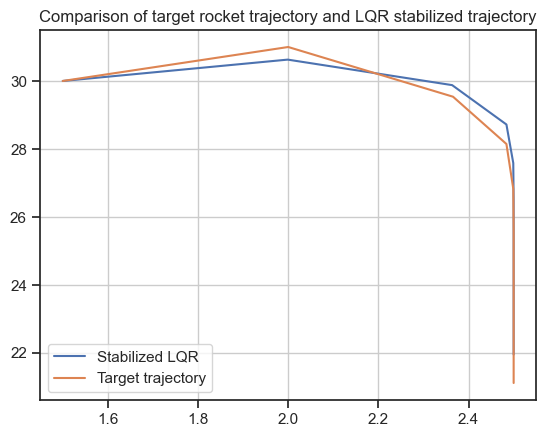

In [235]:
plt.plot(path[:,0],path[:,2],label='Stabilized LQR')
plt.plot(trajectory[:,0],trajectory[:,2],label='Target trajectory')
plt.title("Comparison of target rocket trajectory and LQR stabilized trajectory")
plt.legend()
plt.grid();